In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#from pathlib import Path
import sys
import os
import argparse
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
sys.path.append('../')
import json
from pathlib import Path
from log import logger
import logging
#from lib.io.loadConfigs import *
import lib.io.loadConfigs as loadConfigs
import lib.io.readPollyRawData as readPollyRawData
import lib.interface.picassoProc as picassoProc
import lib.misc.helper as helper
import lib.misc.startscreen as startscreen
import lib.misc.json2nc_mapping as json2nc_mapping

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
## getting root dir of PicassoPy
root_dir0 = Path(os.path.abspath('')).resolve().parent
root_dir = helper.detect_path_type(root_dir0)

print(root_dir0)
print(root_dir)

## setting config files
picasso_default_config_file = Path(root_dir,'lib','config','pollynet_processing_chain_config.json')
print(picasso_default_config_file)
polly_default_config_file = Path(root_dir,'lib','config','polly_global_config.json')
print(polly_default_config_file)
#picasso_config_file = "/pollyhome/Bildermacher2/experimental/PicassoPy/config/pollynet_processing_chain_config_rsd2_24h_exp.json"



/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config.json
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_config.json


In [4]:
# for purpose of the notebook mimic the argparse interface
from types import SimpleNamespace
args = SimpleNamespace()

args.timestamp = '20230618'
args.device = 'arielle'

args.picasso_config_file = "/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config_interface.json"
args.level0_file_to_process = "../../../../localdata/coala/arielle_24h/2023_06_18_Sun_ARI_00_00_01.nc"

In [5]:
import pprint

In [6]:
## start_screen
startscreen.startscreen()

## loading configs as dicts
picasso_config_dict = loadConfigs.loadPicassoConfig(args.picasso_config_file,picasso_default_config_file)
pprint.pprint(picasso_config_dict)
polly_config_array = loadConfigs.readPollyNetConfigLinkTable(picasso_config_dict['pollynet_config_link_file'],timestamp=args.timestamp,device=args.device)
polly_config_file = str(polly_config_array['Config file'].to_string(index=False)).strip()
polly_device = str(polly_config_array['Instrument'].to_string(index=False)).strip()
polly_location = str(polly_config_array['Location'].to_string(index=False)).strip()
polly_asl = str(polly_config_array['asl.'].to_string(index=False)).strip()

output_path = Path(picasso_config_dict["fileinfo_new"]).parent

if polly_config_file:
    polly_config_file_fullname = Path(picasso_config_dict['polly_config_folder'],polly_config_file)
else:
    polly_config_file_fullname = polly_default_config_file

print("polly_config_file_fullname", polly_config_file_fullname)
print("polly_default_config_file", polly_default_config_file)

polly_config_dict = loadConfigs.loadPollyConfig(polly_config_file_fullname, polly_default_config_file)
## adding some information from pollynet_config_link_file (xlsx-file) to polly_config_dict
polly_config_dict['name'] = polly_device
polly_config_dict['site'] = polly_location
polly_config_dict['asl'] = polly_asl

2024-12-16 13:44:03,947 - INFO - picasso_default_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config.json
2024-12-16 13:44:03,953 - INFO - picasso_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config_interface.json
2024-12-16 13:44:03,959 - INFO - pollynet_config_link_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config_links.xlsx


      ____  _                            ____           ___ ____ 
     / __ \(_)________ _______________  / __ \__  __   <  // __ \
    / /_/ / / ___/ __ `/ ___/ ___/ __ \/ /_/ / / / /   / // / / /
   / ____/ / /__/ /_/ (__  |__  ) /_/ / ____/ /_/ /   / // /_/ / 
  /_/   /_/\___/\__,_/____/____/\____/_/    \__, /   /_(_)____/  
                                           /____/                
{'MWRFolder': '/home/hatpro/data/nmy/data/level2/',
 'contact': 'Holger Baars <baars@tropos.de>',
 'defaultFile_folder': '/home/matlab/picasso-nb-interface/configs/pollyDefaults',
 'doneListFile': '/home/matlab/Pollynet_Processing_Chain/run_lists/done_filelist_playground.txt',
 'figDPI': 80,
 'fileinfo_new': '/home/matlab/Pollynet_Processing_Chain/run_lists/fileinfo_playground.txt',
 'flagDebugOutput': False,
 'flagDeleteData': False,
 'flagDeletePreOutputs': True,
 'flagEnableCaliResultsOutput': True,
 'flagEnableDataVisualization': False,
 'flagEnableDataVisualization24h': True,
 'flagEnableResu

2024-12-16 13:44:06,202 - INFO - polly_default_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_config.json
2024-12-16 13:44:06,208 - INFO - polly_config_file: /mnt/c/Users/radenz/dev/picasso-nb-interface/configs/pollyConfigs/arielle_config_20230101.json


polly_config_file_fullname /mnt/c/Users/radenz/dev/picasso-nb-interface/configs/pollyConfigs/arielle_config_20230101.json
polly_default_config_file /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_config.json


In [7]:
rawfile_fullname = args.level0_file_to_process
print(rawfile_fullname)
rawfile = helper.detect_path_type(rawfile_fullname)

../../../../localdata/coala/arielle_24h/2023_06_18_Sun_ARI_00_00_01.nc


In [8]:
rawdata_dict = readPollyRawData.readPollyRawData(filename=rawfile)

## initate picasso-object from class PicassoProc
data_cube = picassoProc.PicassoProc(rawdata_dict,polly_config_dict,picasso_config_dict)


2024-12-16 13:44:10,775 - INFO - reading nc-file: ../../../../localdata/coala/arielle_24h/2023_06_18_Sun_ARI_00_00_01.nc


In [9]:
print(data_cube.polly_config_dict['dtCorMode'])
print(data_cube.polly_config_dict['flagDTCor'])

data_cube.polly_config_dict['flagDTCor'] = True

1
True


In [10]:
#print(data_cube.device)
#print(data_cube.location)
#print(data_cube.date)

## reset date if date in filename differs date within nc-file 
data_cube.reset_date_infile()

## checking for correct mshots
data_cube.check_for_correct_mshots()
#print(data_cube.filter_or_correct_false_mshots())

## setting channelTags
data_cube.setChannelTags()
#print(data_cube.polly_config_dict['channelTags'])
#print(data_cube.channel_dict)

## check for correct date in nc-file
data_cube.reset_date_infile()

## preprocessing
data_cube.preprocessing()
#print(data_cube.rawdata_dict.keys())
#print(data_cube.data_retrievals.keys())

2024-12-16 13:44:27,402 - INFO - date consistency-check... 
2024-12-16 13:44:27,404 - INFO - ... date in nc-file equals date of filename
2024-12-16 13:44:27,418 - INFO - ChannelLabels: ['FR-total-355 nm', 'FR-cross-355 nm', 'FR-387 nm', 'FR-407 nm', 'FR-total-532 nm', 'FR-cross-532 nm', 'FR-607 nm', 'FR-total-1064 nm', 'NR-total-532 nm', 'NR-607 nm', 'NR-total-355 nm', 'NR-387 nm']
2024-12-16 13:44:27,419 - INFO - date consistency-check... 
2024-12-16 13:44:27,420 - INFO - ... date in nc-file equals date of filename
2024-12-16 13:44:27,423 - INFO - starting data preprocessing...
2024-12-16 13:44:27,425 - INFO - ... time conversion
2024-12-16 13:44:27,446 - INFO - ... Deadtime-correction (Mode: 1)
2024-12-16 13:46:11,891 - INFO - ... removing background from signal
2024-12-16 13:46:15,934 - INFO - ... height bin calculations
2024-12-16 13:46:16,023 - INFO - ... mask bins with low SNR
2024-12-16 13:46:33,786 - INFO - ... mask for polarization calibration
2024-12-16 13:46:34,090 - INFO - 

In [11]:
import pickle
with open('sig_40_140.pickle', 'rb') as f:
    comp_ml = pickle.load(f)

print(comp_ml.keys())

dict_keys(['sig532t_40_140', 'sig532c_40_140', 'rawsig532t_40_140', 'rawsig532c_40_140', 'sigDTcor_532t_40_140', 'sigDTcor_532c_40_140'])


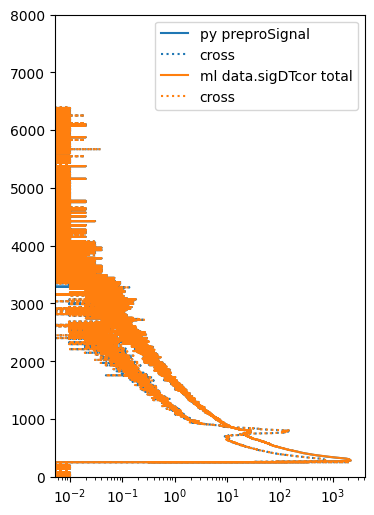

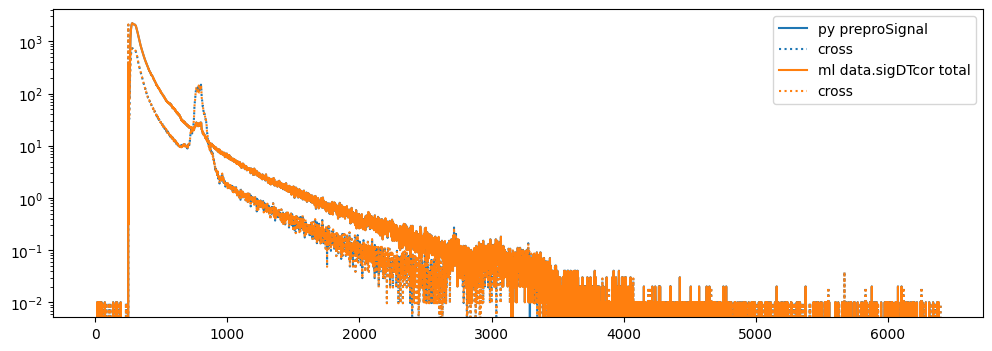

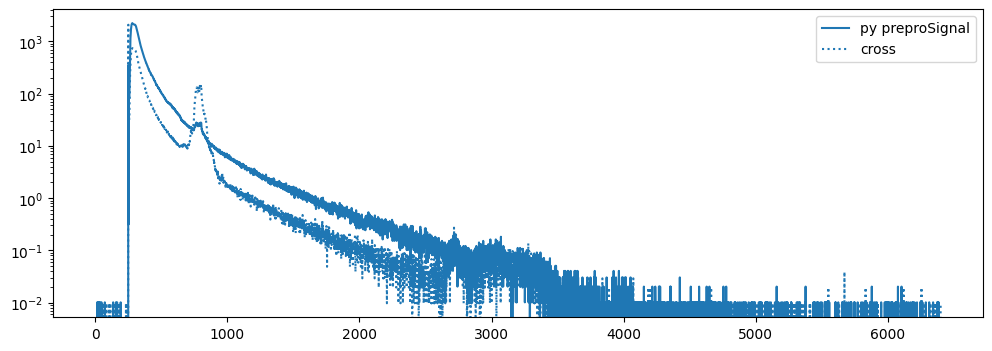

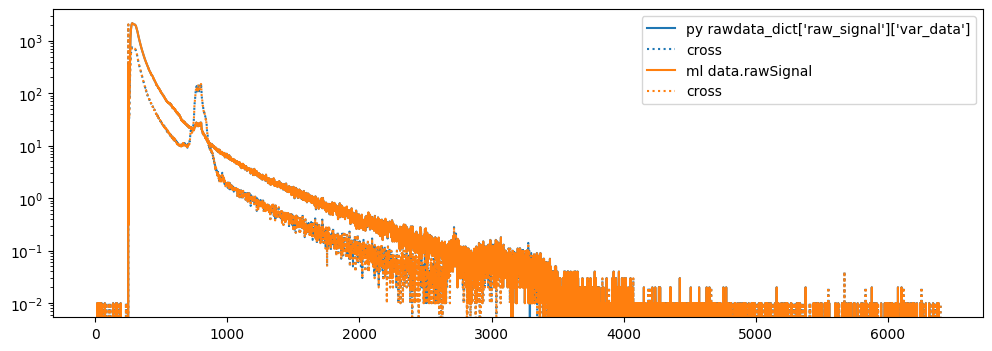

In [12]:
m_preproSig_532_total = np.mean(data_cube.data_retrievals['preproSignal'][39:139,:,4], axis=0)
m_preproSig_532_cross = np.mean(data_cube.data_retrievals['preproSignal'][39:139,:,5], axis=0)

fig, ax = plt.subplots(1, figsize=(4, 6))
ax.plot(m_preproSig_532_total, np.arange(6400), color='C0', label='py preproSignal')
ax.plot(m_preproSig_532_cross, np.arange(6400), color='C0', ls=':', label='cross')

ax.plot(comp_ml['sigDTcor_532t_40_140'], np.arange(6400), color='C1', label='ml data.sigDTcor total')
ax.plot(comp_ml['sigDTcor_532c_40_140'], np.arange(6400), color='C1', ls=':', label='cross')

ax.set_ylim(0, 8000)
ax.set_xscale('log')
ax.legend()

fig, ax = plt.subplots(1, figsize=(12,4))
ax.plot(m_preproSig_532_total, color='C0', label='py preproSignal')
ax.plot(m_preproSig_532_cross, color='C0', ls=':', label='cross')

ax.plot(comp_ml['sigDTcor_532t_40_140'], color='C1', label='ml data.sigDTcor total')
ax.plot(comp_ml['sigDTcor_532c_40_140'], color='C1', ls=':', label='cross')

ax.set_yscale('log')
ax.legend()

fig, ax = plt.subplots(1, figsize=(12,4))
ax.plot(m_preproSig_532_total, color='C0', label='py preproSignal')
ax.plot(m_preproSig_532_cross, color='C0', ls=':', label='cross')

ax.set_yscale('log')
ax.legend()

rawsig_532_total = np.mean(data_cube.rawdata_dict['raw_signal']['var_data'][39:139,:,4], axis=0)
rawsig_532_cross = np.mean(data_cube.rawdata_dict['raw_signal']['var_data'][39:139,:,5], axis=0)
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(rawsig_532_total, color='C0', label="py rawdata_dict['raw_signal']['var_data']")
ax.plot(rawsig_532_cross, color='C0', ls=':', label='cross')

ax.plot(comp_ml['rawsig532t_40_140'], color='C1', label='ml data.rawSignal')
ax.plot(comp_ml['rawsig532c_40_140'], color='C1', ls=':', label='cross')

# ax.plot(comp_ml['readrawsig532t_40_140'], color='C2', label='ml read data.rawSignal')
# ax.plot(comp_ml['readrawsig532c_40_140'], color='C2', ls=':', label='cross')


# ax.set_ylim(0, 6000)
ax.set_yscale('log')
ax.legend()

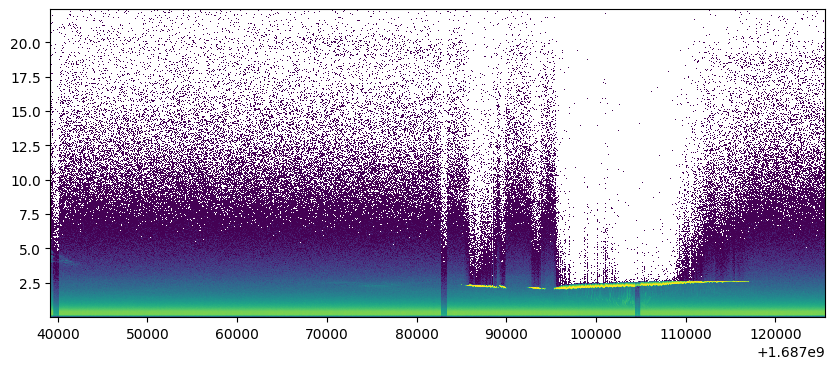

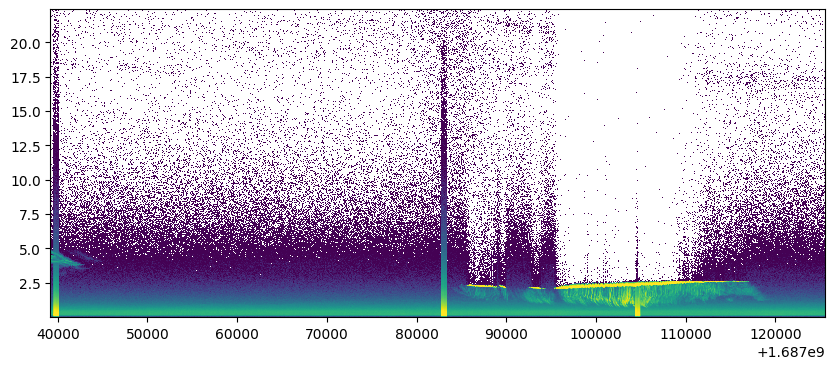

In [13]:
fig, ax = plt.subplots(1, figsize=(10, 4))
pcmesh = ax.pcolormesh(
    data_cube.data_retrievals['time'], np.array(data_cube.data_retrievals['height'])/1000, 
    data_cube.data_retrievals['sigBGCor'][:,:,4].T, shading='nearest',
    norm=matplotlib.colors.LogNorm(vmin=5, vmax=1e4),
    )

fig, ax = plt.subplots(1, figsize=(10, 4))
pcmesh = ax.pcolormesh(
    data_cube.data_retrievals['time'], np.array(data_cube.data_retrievals['height'])/1000, 
    data_cube.data_retrievals['sigBGCor'][:,:,5].T, shading='nearest',
    norm=matplotlib.colors.LogNorm(vmin=5, vmax=1e4),
    )

# ax.set_ylim(top=6)
# cbar = fig.colorbar(pcmesh)
# ax.set_xlabel(f"Time", fontsize=10)
# ax.set_ylabel("Height [km]", fontsize=10)
# cbar.ax.set_ylabel(f"Signal Ch. {ich} ({picassointerface.short_label(channel_labels[ich])})", fontsize=10)
# ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
# ax.xaxis.set_major_locator(matplotlib.dates.HourLocator(interval=3))
# ax.xaxis.set_minor_locator(matplotlib.dates.MinuteLocator(byminute=[0,15,30,45]))
# ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

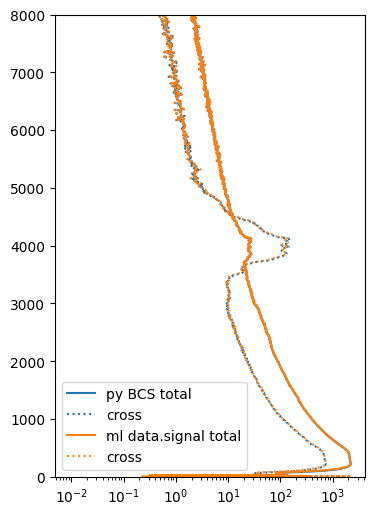

In [14]:
mean_532_total = np.mean(data_cube.data_retrievals['sigBGCor'][39:139,:,4], axis=0)
mean_532_cross = np.mean(data_cube.data_retrievals['sigBGCor'][39:139,:,5], axis=0)

fig, ax = plt.subplots(1, figsize=(4, 6))
ax.plot(mean_532_total, np.array(data_cube.data_retrievals['height']), color='C0', label='py BCS total')
ax.plot(mean_532_cross, np.array(data_cube.data_retrievals['height']), color='C0', ls=':', label='cross')

ax.plot(comp_ml['sig532t_40_140'], np.array(data_cube.data_retrievals['height']), color='C1', label='ml data.signal total')
ax.plot(comp_ml['sig532c_40_140'], np.array(data_cube.data_retrievals['height']), color='C1', ls=':', label='cross')

ax.set_ylim(0, 8000)
ax.set_xscale('log')
ax.legend()





In [15]:
# data_cube.rawdata_dict['raw_signal']['var_data'].shape


In [16]:
print(data_cube.rawdata_dict.keys())

dict_keys(['filename', 'global_attributes', 'raw_signal', 'measurement_shots', 'measurement_time', 'depol_cal_angle', 'measurement_height_resolution', 'laser_rep_rate', 'laser_power', 'laser_flashlamp', 'location_height', 'location_coordinates', 'neutral_density_filter', 'if_center', 'if_fwhm', 'polstate', 'telescope', 'deadtime_polynomial', 'deadtime_polynomial_error', 'discr_level', 'pm_voltage', 'pinhole', 'zenithangle'])


In [17]:
print(data_cube.data_retrievals.keys())

dict_keys(['channel', 'PCR_cor', 'preproSignal', 'BG', 'sigBGCor', 'height', 'alt', 'time', 'time64', 'SNR', 'lowSNRMask', 'depol_cal_ang_p_time_start', 'depol_cal_ang_p_time_end', 'depol_cal_ang_n_time_start', 'depol_cal_ang_n_time_end', 'depCalMask', 'RCS'])


In [18]:
print(data_cube.channel_dict)

{0: 'FR-total-355 nm', 1: 'FR-cross-355 nm', 2: 'FR-387 nm', 3: 'FR-407 nm', 4: 'FR-total-532 nm', 5: 'FR-cross-532 nm', 6: 'FR-607 nm', 7: 'FR-total-1064 nm', 8: 'NR-total-532 nm', 9: 'NR-607 nm', 10: 'NR-total-355 nm', 11: 'NR-387 nm'}


In [19]:
#time = datetime.datetime.timestamp(datetime.datetime.now(datetime.timezone.utc))
print(data_cube.date)
data_cube.data_retrievals['time'][0], data_cube.data_retrievals['time'][-1] 

20230618


(1687039200, 1687125570)

In [20]:
data_cube.data_retrievals.keys()

dict_keys(['channel', 'PCR_cor', 'preproSignal', 'BG', 'sigBGCor', 'height', 'alt', 'time', 'time64', 'SNR', 'lowSNRMask', 'depol_cal_ang_p_time_start', 'depol_cal_ang_p_time_end', 'depol_cal_ang_n_time_start', 'depol_cal_ang_n_time_end', 'depCalMask', 'RCS'])

In [21]:
pol_cali = data_cube.polarizationCaliD90()

2024-12-16 13:47:34,611 - INFO - and even a 355 channel


starting loadGHK
data_cube keys  dict_keys(['rawdata_dict', 'polly_config_dict', 'picasso_config_dict', 'device', 'location', 'date', 'num_of_channels', 'num_of_profiles', 'data_retrievals', 'channel_dict', 'flags', 'flag_355_total_FR', 'flag_355_cross_FR', 'flag_355_parallel_FR', 'flag_355_total_NR', 'flag_387_total_FR', 'flag_387_total_NR', 'flag_407_total_FR', 'flag_407_total_NR', 'flag_532_total_FR', 'flag_532_cross_FR', 'flag_532_parallel_FR', 'flag_532_total_NR', 'flag_532_cross_DFOV', 'flag_532_rr_FR', 'flag_607_total_FR', 'flag_607_total_NR', 'flag_1058_total_FR', 'flag_1064_total_FR', 'flag_1064_cross_FR', 'flag_1064_total_NR'])
dict_keys(['flagCorrectFalseMShots', 'flagFilterFalseMShots', 'flagForceMeasTime', 'flagDTCor', 'flagSigTempCor', 'flagLCCalibration', 'flagDepolCali', 'flagWVCalibration', 'flagUsePreviousDepolCali', 'flagUsePreviousWVconst', 'flagUsePreviousLC', 'flagUseManualRefH', 'flagUseSameRefH', 'flagAutoscaleRCS', 'flagMolDepolCali', 'flagTransCor', 'flagUseTh

2024-12-16 13:47:35,604 - INFO - pol_cali_355   {'eta': [19.368045522896264, 19.38380125421764, 19.584845925714074], 'eta_std': [0.3166358591227246, 0.31890750578915217, 0.3423738644550827], 'time_start': [1687039590, 1687082790, 1687104390], 'time_end': [1687040100, 1687083300, 1687104900], 'status': 1, 'eta_best': 19.368045522896264}
2024-12-16 13:47:35,607 - INFO - and even a 532 channel
2024-12-16 13:47:35,798 - INFO - pol_cali_532   {'eta': [28.495323267051297, 28.629593457507788, 28.788399775483036], 'eta_std': [0.4043573463320397, 0.3872948853501746, 0.3417234358677146], 'time_start': [1687039590, 1687082790, 1687104390], 'time_end': [1687040100, 1687083300, 1687104900], 'status': 1, 'eta_best': 28.788399775483036}
2024-12-16 13:47:35,799 - WARNING - calibrateGHK no 1064 channel


In [22]:
# dict(pol_cali[532][-1])

import pickle

# savestr = f"{starttime:%Y%m%d_%H%M}_polCali532_python.pickle"
savestr = f"20230618_HHMM_polCali532_python.pickle"

# with open(savestr, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    # pickle.dump(dict(pol_cali[532][-1]), f, pickle.HIGHEST_PROTOCOL)

In [23]:
# data_cube.cloudScreen and
# data_cube.cloudFreeSeg are not implemented yet.
# For testing reasons set the intervals manually:

data_cube.cloudFreeSeg()
data_cube.clFreeGrps = [
    [35, 300],
    [2500, 2800]
]

In [24]:
data_cube.polly_config_dict['meteorDataSource'] = 'nc_cloudnet'
data_cube.polly_config_dict['meteo_folder'] = '/mnt/c/Users/radenz/localdata/coala/model_ecmwf'
data_cube.polly_config_dict['meteo_file'] = ".*/{0:%Y}/{0:%Y%m%d}.*.nc"

data_cube.loadMeteo()

candidates  ['/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230616_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230617_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230618_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230619_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230620_neumayer_ecmwf.nc']
regex  re.compile('.*/2023/20230618.*.nc')
filename  ['/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230618_neumayer_ecmwf.nc']


<xarray.Dataset> Size: 9MB
Dimensions:      (time: 97, height: 3000)
Coordinates:
  * height       (height) float64 24kB 3.75 11.22 18.69 ... 2.24e+04 2.241e+04
  * time         (time) datetime64[ns] 776B 2023-06-18 ... 2023-06-19
Data variables:
    temperature  (time, height) float64 2MB 248.8 249.0 249.4 ... 184.9 184.9
    pressure     (time, height) float64 2MB 9.883e+04 9.88e+04 ... 2.685e+03
    rh           (time, height) float64 2MB 0.7718 0.7593 ... 0.6816 0.681
    q            (time, height) float64 2MB 0.0003288 0.0003281 ... 2.079e-06
Attributes:
    source:               ECMWF Integrated Forecast System (IFS)
    institution:          European Centre for Medium-Range Weather Forecasting
    initialization_time:  2023-06-18 00:00:00 +00:00
    Conventions:          CF-1.8
    title:                ECMWF IFS single-site output over Neumayer III
    location:             Neumayer III
    file_uuid:            7df280a3-bc0c-4ae6-8df6-ff0bfc201570
    cloudnet_file_type:   mo

(-100.0, 1000.0)

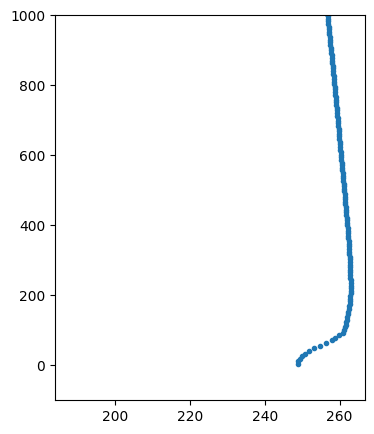

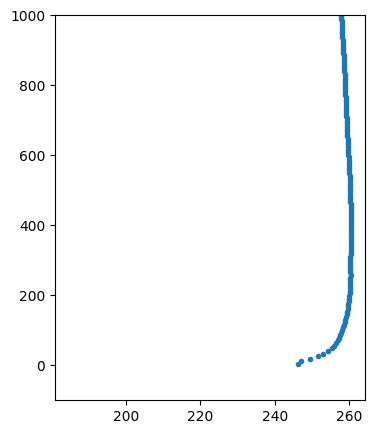

In [25]:
print(data_cube.met.ds)

fig, ax = plt.subplots(figsize=(4,5))
ax.plot(data_cube.met.ds.isel(time=0)['temperature'], data_cube.met.ds.height, '.')
ax.set_ylim(-100, 1000)

fig, ax = plt.subplots(figsize=(4,5))
ax.plot(data_cube.met.ds.isel(time=-1)['temperature'], data_cube.met.ds.height, '.')
ax.set_ylim(-100, 1000)

In [26]:
data_cube.calcMolecular()

time slices of cloud free  [array(['2023-06-18T00:17:30.000000', '2023-06-18T02:30:00.000000'],
      dtype='datetime64[us]'), array(['2023-06-18T20:50:00.000000', '2023-06-18T23:20:00.000000'],
      dtype='datetime64[us]')]
len mean_profiles 2
shape of the molecular scattering (2, 3000)
for the wavelengths  [355, 387, 407, 532, 607, 1058, 1064]


In [27]:
print(data_cube.mol_profiles.keys())


dict_keys(['mBsc_355', 'mExt_355', 'mBsc_387', 'mExt_387', 'mBsc_407', 'mExt_407', 'mBsc_532', 'mExt_532', 'mBsc_607', 'mExt_607', 'mBsc_1058', 'mExt_1058', 'mBsc_1064', 'mExt_1064', 'number_density'])


In [30]:
m_reference = np.load('20230618_0000_rayleigh_cal_testinterval_matlab.npz')

print(m_reference.files)
print(m_reference['cloud_free'])

m_py = data_cube.mol_profiles
print(m_py.keys())

['height', 'number_density', 'cloud_free', 'mBsc355', 'mExt355', 'mBsc387', 'mExt387', 'mBsc407', 'mExt407', 'mBsc532', 'mExt532', 'mBsc607', 'mExt607', 'mBsc1064', 'mExt1064']
[[  36  301]
 [2501 2801]]
dict_keys(['mBsc_355', 'mExt_355', 'mBsc_387', 'mExt_387', 'mBsc_407', 'mExt_407', 'mBsc_532', 'mExt_532', 'mBsc_607', 'mExt_607', 'mBsc_1058', 'mExt_1058', 'mBsc_1064', 'mExt_1064', 'number_density'])


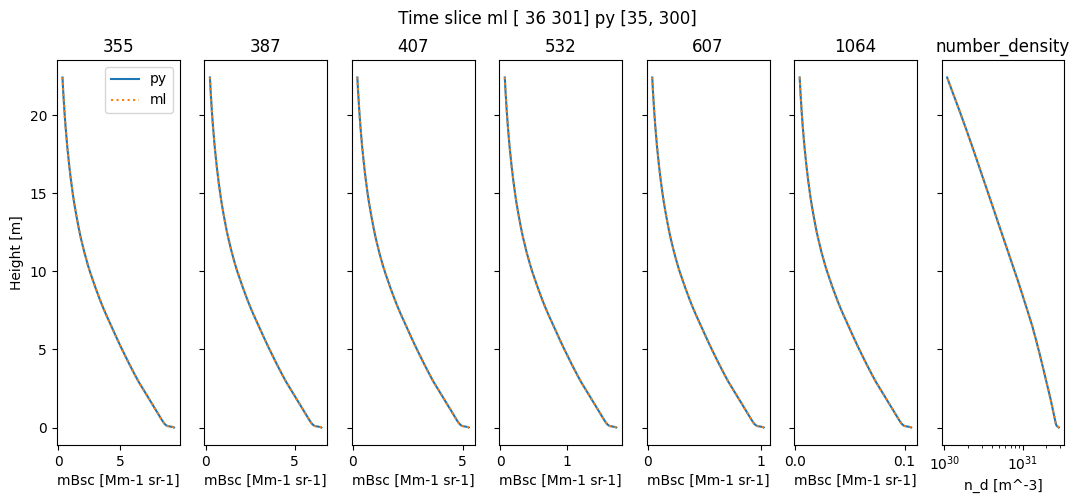

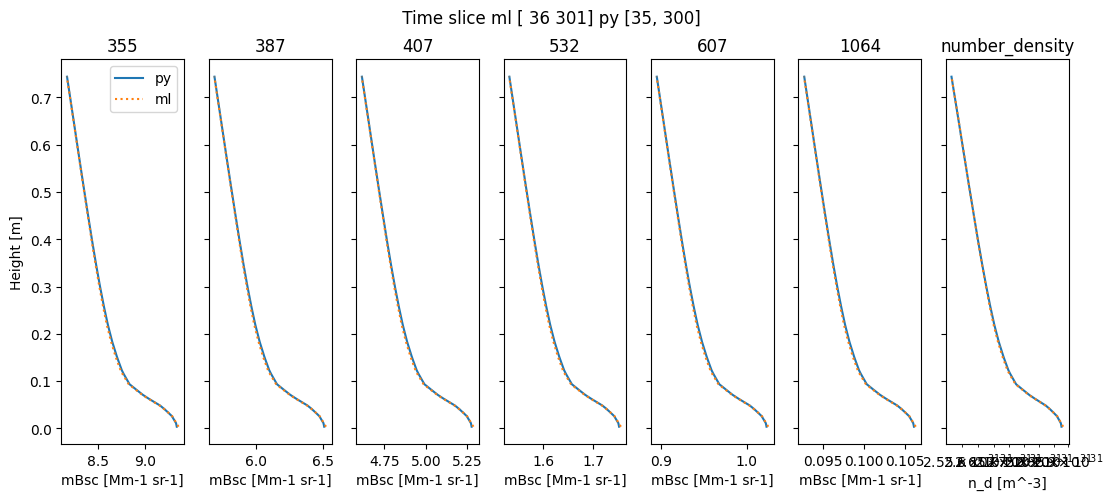

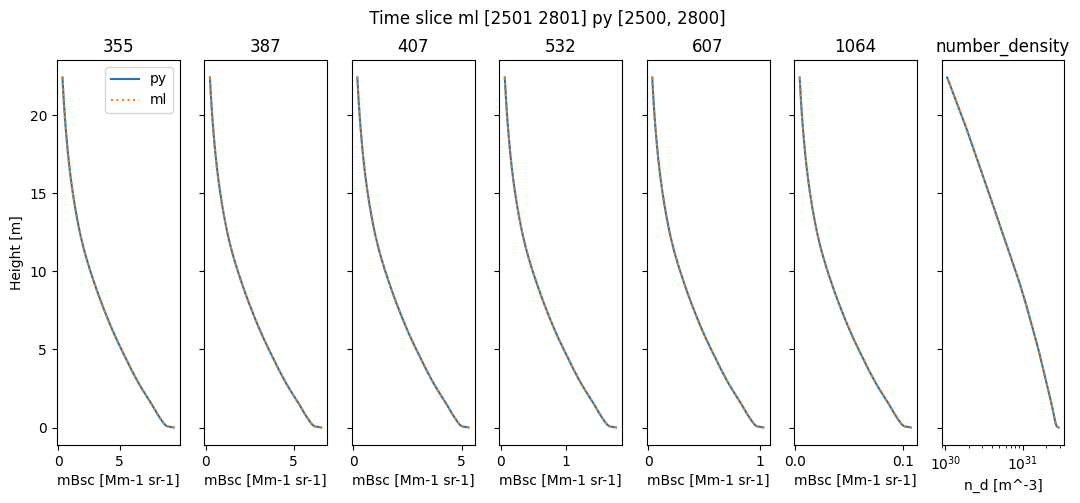

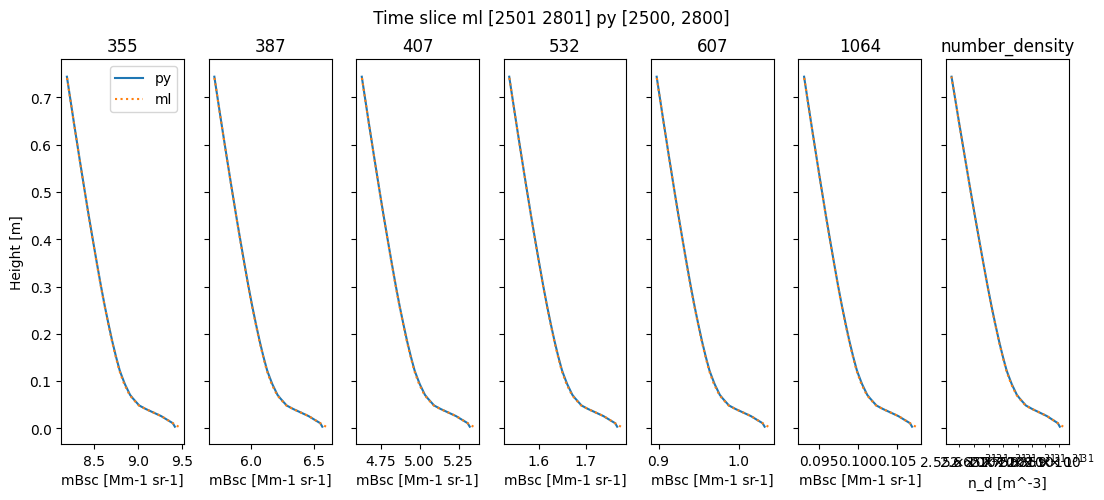

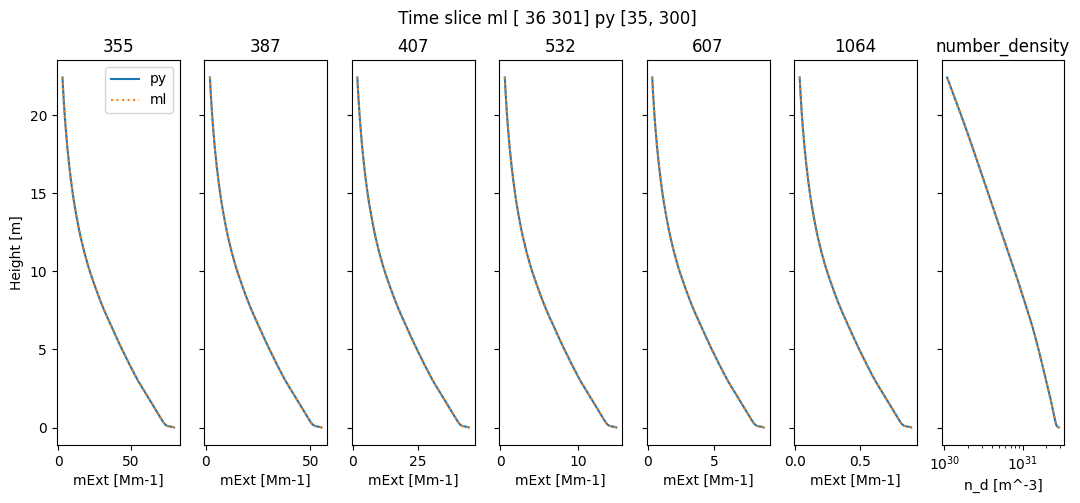

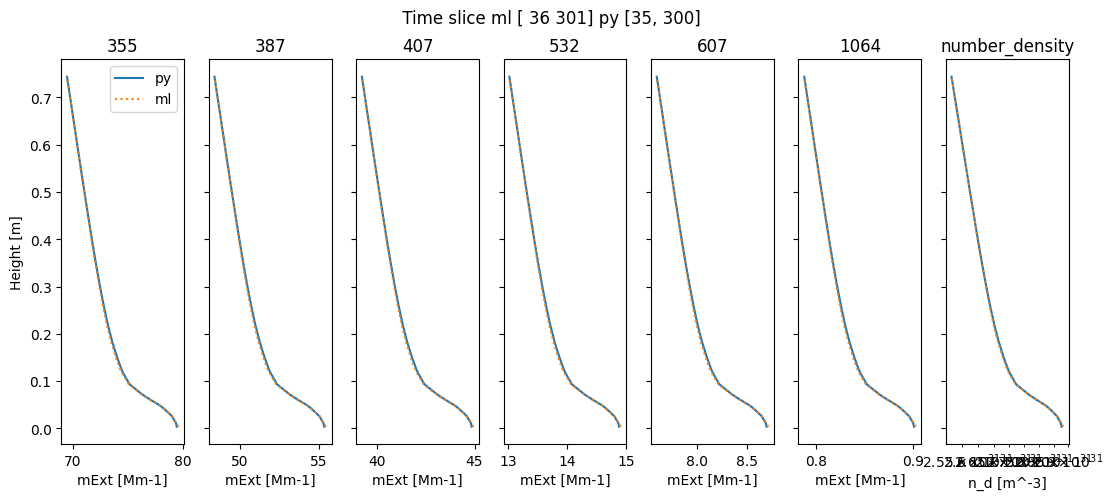

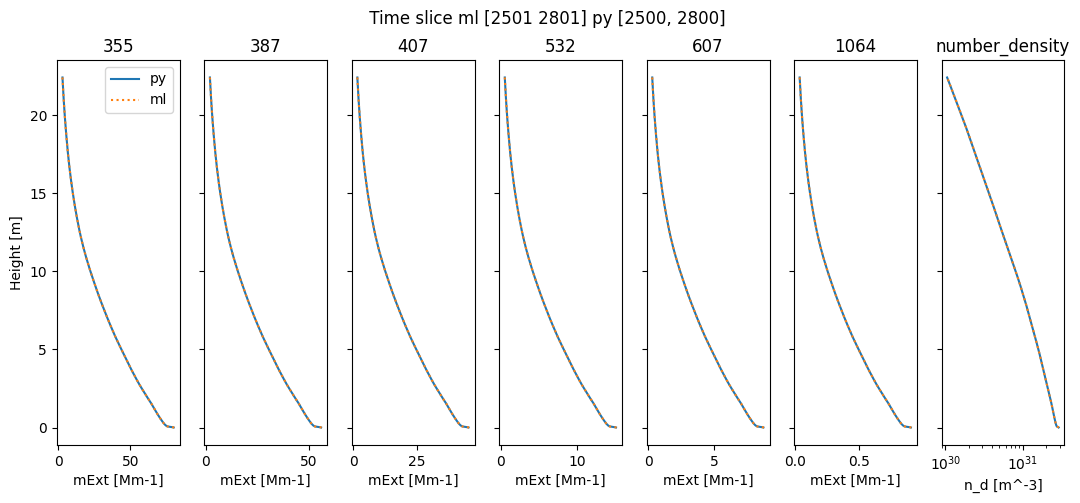

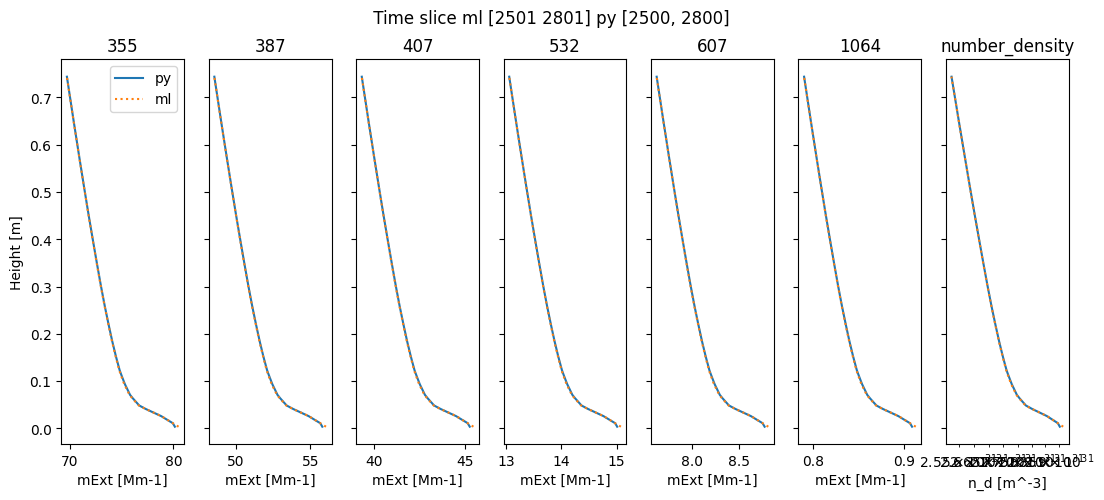

In [53]:
comparisons = [
    ['mBsc', 0, -1],
    ['mBsc', 0, 100],
    ['mBsc', 1, -1],
    ['mBsc', 1, 100],
    ['mExt', 0, -1],
    ['mExt', 0, 100],
    ['mExt', 1, -1],
    ['mExt', 1, 100],
]

for var, icld, imax in comparisons:
    # print(m_reference['height'])
    fig, ax = plt.subplots(1,7 ,figsize=(13,5), sharey=True)
    ax[0].plot(m_py[f'{var}_355'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-', label='py')
    ax[0].plot(m_reference[f'{var}355'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':', label='ml')
    ax[0].set_ylabel('Height [m]')
    ax[0].legend()
    ax[0].set_title('355')
    
    ax[1].plot(m_py[f'{var}_387'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[1].plot(m_reference[f'{var}387'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[1].set_title('387')
    
    ax[2].plot(m_py[f'{var}_407'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[2].plot(m_reference[f'{var}407'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[2].set_title('407')
    
    ax[3].plot(m_py[f'{var}_532'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[3].plot(m_reference[f'{var}532'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[3].set_title('532')
    
    ax[4].plot(m_py[f'{var}_607'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[4].plot(m_reference[f'{var}607'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[4].set_title('607')
    
    ax[5].plot(m_py[f'{var}_1064'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[5].plot(m_reference[f'{var}1064'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[5].set_title('1064')
    
    for i in range(0,6):
        if var == 'mBsc':
            ax[i].set_xlabel(f'{var} [Mm-1 sr-1]')
        elif var == 'mExt':
            ax[i].set_xlabel(f'{var} [Mm-1]')
    
    ax[6].plot(m_py['number_density'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[6].plot(m_reference['number_density'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[6].set_xlabel('n_d [m^-3]')
    ax[6].set_title('number_density')
    ax[6].set_xscale('log')
    
    # ax[0].set_ylim(0, 1000)
    fig.suptitle(f" Time slice ml {m_reference['cloud_free'][icld]} py {data_cube.clFreeGrps[icld]}")
    
    fig.savefig(f"{var}_icld_{icld}_hmax_{data_cube.met.ds.height[imax].values:.0f}.png")

    